## Загрузка данных

In [1]:
import pandas as pd
aliases = pd.read_csv('data/Aliases.csv')
emailreceivers = pd.read_csv('data/EmailReceivers.csv')
emails = pd.read_csv('data/Emails.csv')
persons = pd.read_csv('data/Persons.csv')

In [2]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [3]:
data = pd.DataFrame(emails[['MetadataSubject', 'ExtractedBodyText']])
data.columns = ['subject', 'body']
data.fillna('', inplace=True)

In [4]:
# data.head(20)

## Предобработка и анализ

Предобработаем сперва темы писем. В них содержатся шумовые токены вроде "FWD:" или "Re:". Избавимся от них с помощью регулярных выражений.
Затем предобработаем тексты писем, в которых также содержатся шумовые строки, начинающиеся с подстрок "Re:" или "H:". Стоит также удалить шумовые тэги, такие как "From:", штампы "U.S. Department...", отметки времени и/или даты. Также удалим строки с номерами документов вроде "Case No" и строки с числами.

In [5]:
import re
def is_date(string):
    try:
        parse(string)
        return True
    except:
        return False
    
def has_numbers(string):
    return bool(re.search(r'\d', string))

def process_body(elem):
    lines = elem.splitlines()
    trashpattern = re.compile(r"^(Doc No\\..*|Case No\\.|H <.*@.*>|.*@.*|From .|To:.|For:.*|Subject:.|U.S. Department of State$)")
    datepattern = re.compile(r"Date: \d{2}/\d{2}/\d{4}")
    timepattern = re.compile(r".*\d{1,2}:(\d{2}\s(?:AM|PM))")
    keypattern = re.compile(r"\s*(Fwd|Fw|Fvv|FVV|FW|Re|re|RE|H):\s*")
    numpattern = re.compile(r".*(\d*-\d*|\d+\b).*")
    lines = list(filter(lambda line: not datepattern.match(line) and not trashpattern.match(line) and not keypattern.match(line)
            and not timepattern.match(line) and not numpattern.match(line) and len(line) > 10,lines))
    return '\n'.join(lines)

def process_subject(elem):
    if elem == '':
        return elem
    keypattern = r's*(Fwd|Fw|Fvv|FVV|FW|Re|re|RE|H):\s*'
    subject = re.sub(keypattern, "", elem)
    subject = re.sub(keypattern, "", elem)
    return subject

data['subjectProc'] = data.subject.apply(process_subject)
data['bodyProc'] = data.body.apply(process_body)

In [6]:
# data.head(20)

In [7]:
print(len(data))

7945


### Биграммы из текста

In [8]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
stopset = list(stopwords.words('english')) + ["'s"] + ["n't"] + ['']
punctset = string.punctuation + '—' + '``' + "'" + "•"

In [9]:
tokenset = list(list(filter(lambda token: token.lower() not in stopset and token not in punctset and len(token) > 3, word_tokenize(line)))
              for index, text in data.bodyProc.iteritems() for line in text.splitlines())
tokenset = list(list("".join(l for l in list(filter(lambda c: c not in punctset, token))) for token in doc)
               for doc in tokenset)
bigrams = list(bg for elem in tokenset for bg in list(ngrams(elem,2)))

C:\Users\y.efimov\AppData\Local\Continuum\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


In [10]:
print(len(tokenset))
print(tokenset[516])

31217
['wait', 'exactly', 'investigation', 'finally', 'confirms', 'best', 'information']


Выведем 5 наиболее часто встречающихся биграмм

In [11]:
from collections import Counter
frequencies = Counter(bigrams)

In [12]:
print(frequencies.most_common(5))

[(('United', 'States'), 325), (('White', 'House'), 239), (('Secretary', 'State'), 147), (('State', 'Department'), 134), (('health', 'care'), 112)]


### Биграммы с помощью NLTK по PMI

In [12]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokens = [token for tokens in tokenset for token in tokens]

NameError: name 'tokenset' is not defined

In [26]:
word_fd = nltk.FreqDist(tokens)
bigram_fd = nltk.FreqDist(nltk.bigrams(tokens))
finder = BigramCollocationFinder(word_fd, bigram_fd)
sorted(finder.nbest(bigram_measures.raw_freq, 2))

[('United', 'States'), ('White', 'House')]

In [27]:
scored = finder.score_ngrams(bigram_measures.raw_freq)

In [28]:
len(finder.score_ngrams(bigram_measures.raw_freq))

166368

In [29]:
finder.apply_word_filter(lambda w: w.lower() in stopset + [''])

In [30]:
len(finder.score_ngrams(bigram_measures.raw_freq))

166201

In [37]:
sorted(finder.above_score(bigram_measures.raw_freq, 1.0 / len(tuple(nltk.bigrams(tokens)))))

[('101st', 'Airborne'),
 ('10am', 'Call'),
 ('10th', 'Dodd'),
 ('11th', 'attacks'),
 ('11th', 'hour'),
 ('12th', 'asked'),
 ('14th', 'Floor'),
 ('14th', 'pass'),
 ('15minutes', 'conference'),
 ('1960s', 'accuse'),
 ('1990s', 'Republicans'),
 ('19th', 'Amendment'),
 ('19th', 'century'),
 ('20th', 'century'),
 ('21st', 'century'),
 ('35th', 'anniversary'),
 ('AGNA', 'leadership'),
 ('AGREEMENT', 'SENSITIVE'),
 ('AIPAC', 'Presidents'),
 ('ANCHORS', 'APPROACH'),
 ('APPROACH', 'FARM'),
 ('APPROACH', 'identified'),
 ('APPROVE', 'High'),
 ('ARRIVE', 'Private'),
 ('ARTS', 'LIVING'),
 ('ASEAN', 'China'),
 ('ASEAN', 'plus'),
 ('AUCA', 'president'),
 ('Abbas', 'agree'),
 ('Abdul', 'Ghani'),
 ('Abdulfatah', 'Younis'),
 ('Abedin', 'Huma'),
 ('Abedin', 'Hume'),
 ('Abedin', 'Jake'),
 ('Abedin', 'Kennedy'),
 ('Abedin', 'Lona'),
 ('Abedin', 'print'),
 ('Abraham', 'Lincoln'),
 ('Absolute', 'Absolute'),
 ('Abyei', 'understand'),
 ('Academy', 'Sciences'),
 ('Accomplishments', 'Date'),
 ('According', 'Huds

In [31]:
sorted(finder.nbest(bigram_measures.raw_freq, 2))

[('United', 'States'), ('White', 'House')]

Получили те же наиболее часто встречающиеся биграммы.

## Кластеризация писем

Сформируем признаки.

In [13]:
texts = list(text.lower().replace('\n', '') for index, text in data.bodyProc.iteritems())
preproc_texts = list(' '.join(elem for elem in list(filter(lambda token: token not in stopset and len(token) > 3, word_tokenize(text))))
                     for text in texts)

In [14]:
preproc_texts = list(''.join(elem for elem in list(filter(lambda c: c not in punctset, list(text)))) for text in preproc_texts)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
object_feature = vectorizer.fit_transform(preproc_texts)

In [16]:
print(object_feature.shape)

(7945, 2673)


In [19]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(object_feature)

In [15]:
# dbscan
# Latent Dirichlet Allocation?? -> sklearn

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(object_feature)

### Иерархическая кластеризация

In [18]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

In [19]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [15]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
preds = model.fit_predict(object_feature.toarray())

In [16]:
print(list(preds))

[1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [ ]:
vectorizer.get_feature_names()

In [21]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [16]:
import sys
sys.setrecursionlimit(5000)

In [ ]:
plt.figure(figsize=(15,20))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data[:20]

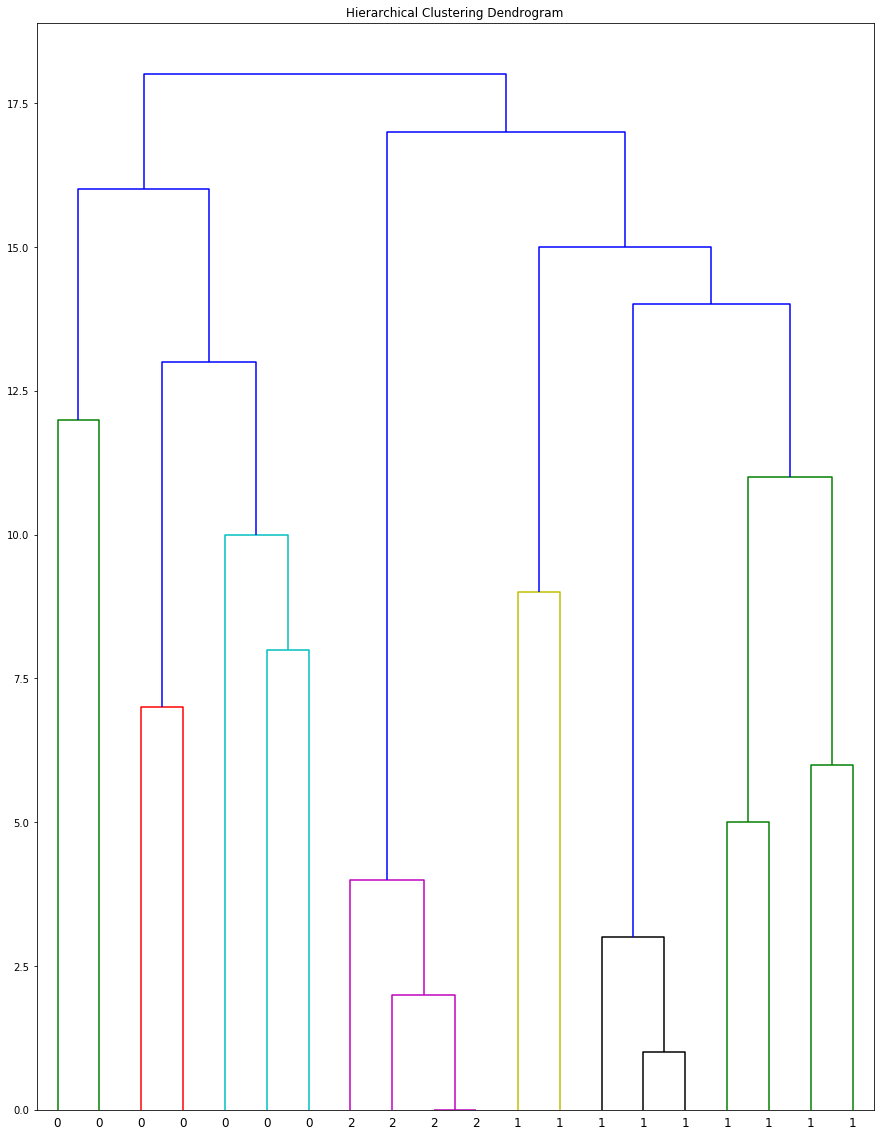

In [34]:
model = AgglomerativeClustering(n_clusters=3)

plt.figure(figsize=(15,20))
model = model.fit(x)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)

# plt.figsize(20,40)
plt.show()

## KMeans

In [33]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(object_feature.toarray())
print(preds[:30])

[0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0]


In [34]:
## target value??


## SVD + KMeans

In [35]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(object_feature)
preds = model.fit_predict(features)
print(preds)

[1 1 1 ..., 1 1 1]
